In [1]:
import os
import pickle
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize
import traceback
import matplotlib.gridspec as gridspec

'''
Obviously need SimInfo pickles from Config_dir
Update the newest Merians from update_merians.ipynb
what needs to be run to make this work
Reff and Profiles from ImageCollection, dont think I need to run isophote masking, except maybe for x00y00
StShapes, DMShapes from 3DShapes
smoothed shapes from 3DShapesSmoothing
halotypes from halotypes.py, in the case of Merians they are all simply centrals
masses from get_masses.py
try/except blocks should catch any mismatches, so don't need to worry too much about everything being perfect.
'''

def T(ba,ca):
    return( (1-ba**2)/(1-ca**2) )

import StellarDMTracing as sdt

def smooth_and_filter_data(rbins, ba, ca):
    k = 4
    s_factor = 1
    """
    Smooth and filter data, handling a few NaN values gracefully.

    Parameters:
    rbins, ba, ca: array-like, input data
    k: int, degree of the smoothing spline (default 3)
    s_factor: float, smoothing factor as a fraction of len(rbins) (default 0.01)
    residual_threshold, jump_threshold, jump_percentage: unused in this version

    Returns:
    rbins, ba, ca: filtered arrays
    ba_s, ca_s: smoothed spline functions
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Remove rows where either ba or ca is NaN
    mask = ~np.isnan(ba) & ~np.isnan(ca)
    rbins_filtered = rbins[mask]
    ba_filtered = ba[mask]
    ca_filtered = ca[mask]

    # Calculate smoothing parameter
    s = s_factor * len(rbins_filtered)

    # Create splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # Print some diagnostic information
    # print(f"Total data points: {len(rbins)}")
    # print(f"Data points after NaN removal: {len(rbins_filtered)}")
    # print(f"NaN percentage: {(1 - len(rbins_filtered)/len(rbins))*100:.2f}%")

    n = len(rbins_filtered)
    # calculate residuals and remove outliers
    ba_residuals = ba_filtered - ba_s(rbins_filtered)
    ca_residuals = ca_filtered - ca_s(rbins_filtered)
    # calculate the standard deviation of the residuals
    ba_std = np.std(ba_residuals)
    ca_std = np.std(ca_residuals)
    # remove outliers
    d = 3

    mask = np.abs(ba_residuals) < d * ba_std

    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    mask = np.abs(ca_residuals[mask]) < d * ca_std
    rbins_filtered = rbins_filtered[mask]
    ba_filtered = ba_filtered[mask]
    ca_filtered = ca_filtered[mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)

    # remove any points that are isolated in space
    # calculate the difference between each point

    diff = np.diff(rbins_filtered, prepend=0)
    # print(diff)
    # mask isolated points
    mask = diff > 1
    # print(mask)
    # print(rbins_filtered[mask])
    # print(diff[mask])
    rbins_filtered = rbins_filtered[~mask]
    ba_filtered = ba_filtered[~mask]
    ca_filtered = ca_filtered[~mask]
    # Recreate splines
    ba_s = UnivariateSpline(rbins_filtered, ba_filtered, k=k, s=s)
    ca_s = UnivariateSpline(rbins_filtered, ca_filtered, k=k, s=s)
    # Print some diagnostic information
    # print(f"Data points after outlier removal: {len(rbins_filtered)}")
    # print(f"Outlier percentage: {(1 - len(rbins_filtered)/len(rbins))*100:.2f}%")

    # def clip_function(func):
    #     def clipped(x):
    #         return np.clip(func(x), 0, 1)
    #
    #     return clipped
    #
    # # clip the function to 0,1
    # ba_s_c = clip_function(ba_s)
    # ca_s_c = clip_function(ca_s)

    return rbins_filtered, ba_filtered, ca_filtered, ba_s, ca_s



def nanfunction(x):
    return x*0 +10
#define color scheme to use for plots as a dict




In [6]:
# add ../ to path
import sys
import os
import importlib
sys.path.append('/home/bk639/MorphologyMeasurements/Code')
import PlotClasses
#display classes in PlotClasses
#print(dir(PlotClasses))
#reload(PlotClasses)
importlib.reload(PlotClasses)
importlib.reload(sdt)

<module 'StellarDMTracing' from '/home/bk639/MorphologyMeasurements/Code/IntrinsicShapes/StellarDMTracing.py'>

['../PickleFiles/SimulationInfo.MerianSIDM.pickle', '../PickleFiles/SimulationInfo.MerianCDM.pickle']
number in sample at reff_multi 1: 35


/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/bk639/miniconda3/envs/shapes/lib/python3.12/

SIDM galaxies: B_D/B_* mean: nan, std: nan
B_d: nan +/- nan
B_s: nan +/- nan
CDM galaxies: B_D/B_* mean: 1.22, std: 0.17
B_d: 0.86 +/- 0.10
B_s: 0.72 +/- 0.14
SIDM galaxies: C_D/C_* mean: nan, std: nan
C_d: nan +/- nan
C_s: nan +/- nan
CDM galaxies: C_D/C_* mean: 2.06, std: 0.57
C_d: 0.61 +/- 0.09
C_s: 0.32 +/- 0.10
SIDM galaxies: T_D/T_* mean: nan, std: nan
T_d: nan +/- nan
T_s: nan +/- nan
CDM galaxies: T_D/T_* mean: 0.81, std: 0.24
T_d: 0.42 +/- 0.24
T_s: 0.53 +/- 0.26
['../PickleFiles/SimulationInfo.MerianSIDM.pickle', '../PickleFiles/SimulationInfo.MerianCDM.pickle']
sim: r431.romulus25cvdXsec, hid: 1, ba_s: 0.76, ca_s: 0.14, ba_d: 0.87, ca_d: 0.50
sim: r515, hid: 1, ba_s: 0.87, ca_s: 0.15, ba_d: 0.84, ca_d: 0.44
sim: r634, hid: 1, ba_s: 0.56, ca_s: 0.01, ba_d: 0.90, ca_d: 0.58
number in sample at reff_multi 2: 34


/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bk639/miniconda3/envs/shapes/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/bk639/miniconda3/envs/shapes/lib/python3.12/

SIDM galaxies: B_D/B_* mean: nan, std: nan
B_d: nan +/- nan
B_s: nan +/- nan
CDM galaxies: B_D/B_* mean: 1.10, std: 0.09
B_d: 0.86 +/- 0.13
B_s: 0.79 +/- 0.14
SIDM galaxies: C_D/C_* mean: nan, std: nan
C_d: nan +/- nan
C_s: nan +/- nan
CDM galaxies: C_D/C_* mean: 2.06, std: 0.74
C_d: 0.58 +/- 0.10
C_s: 0.32 +/- 0.12
SIDM galaxies: T_D/T_* mean: nan, std: nan
T_d: nan +/- nan
T_s: nan +/- nan
CDM galaxies: T_D/T_* mean: 0.92, std: 0.58
T_d: 0.38 +/- 0.28
T_s: 0.43 +/- 0.26


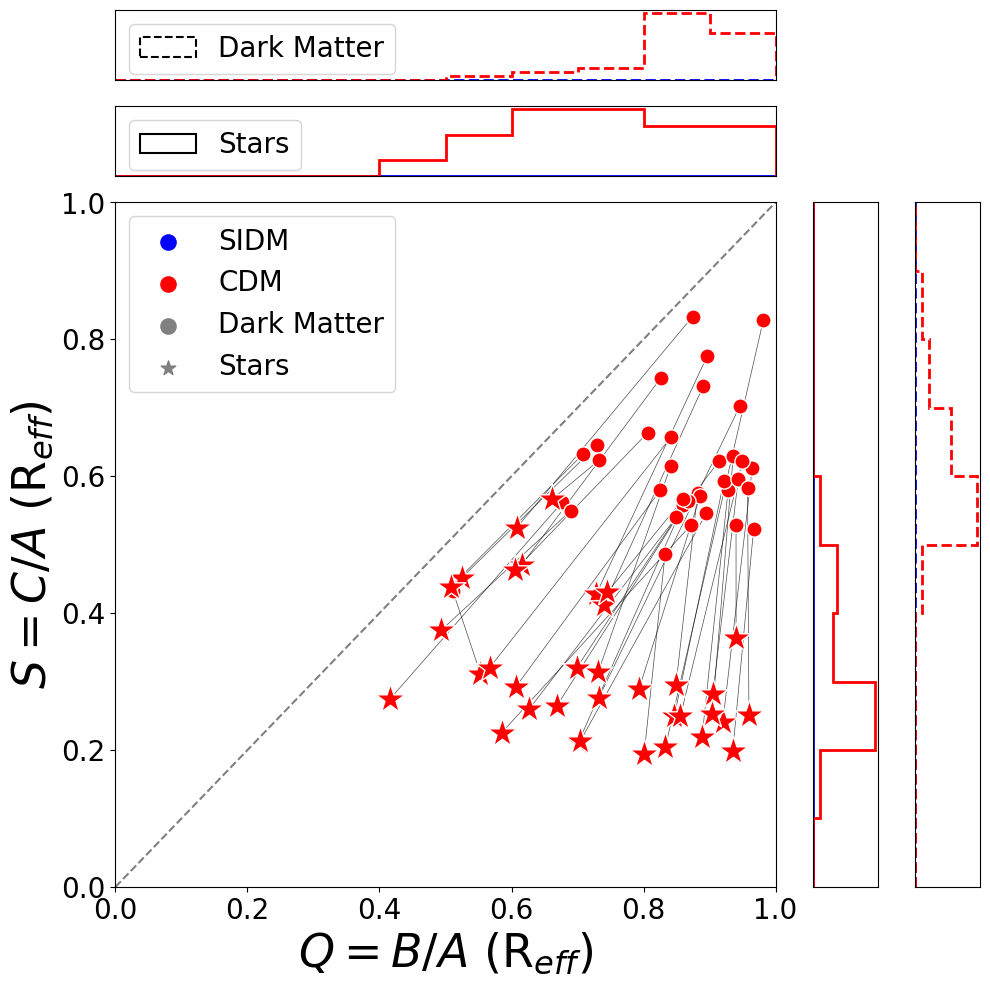

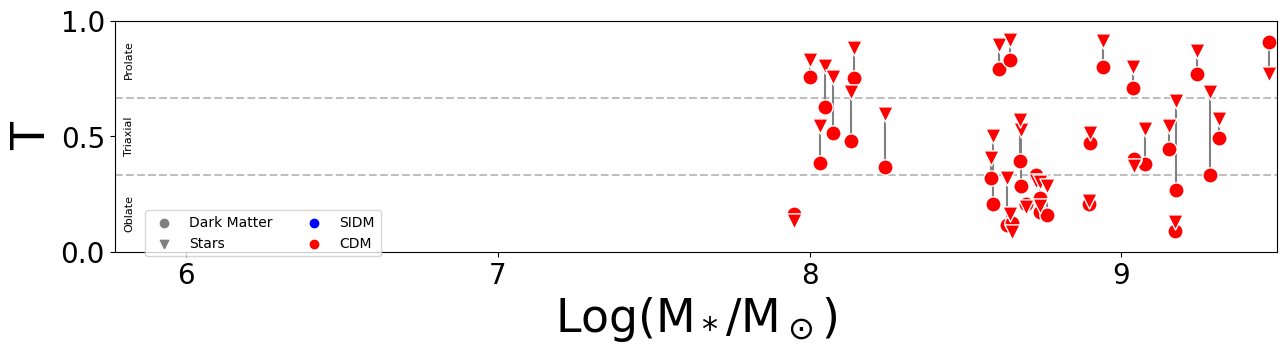

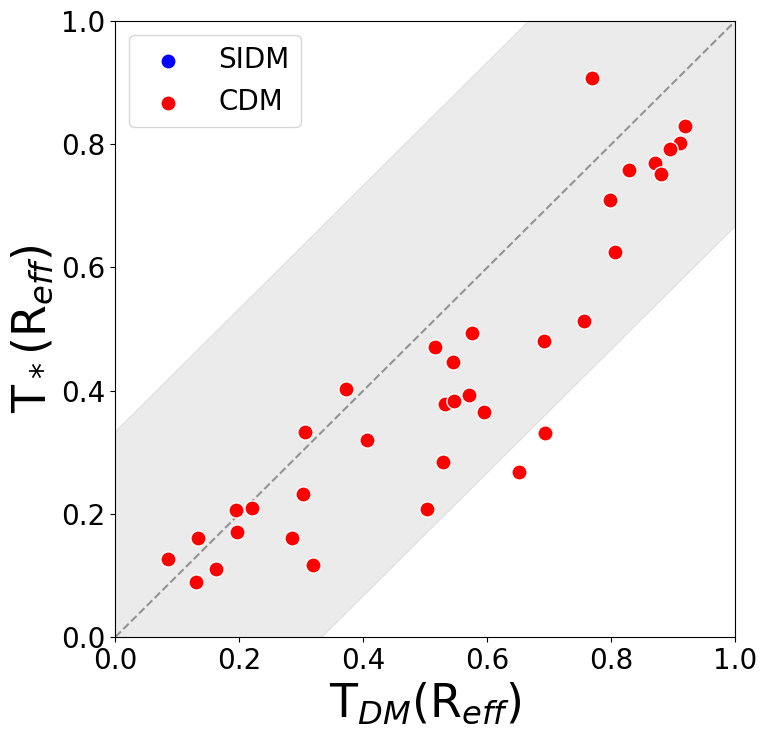

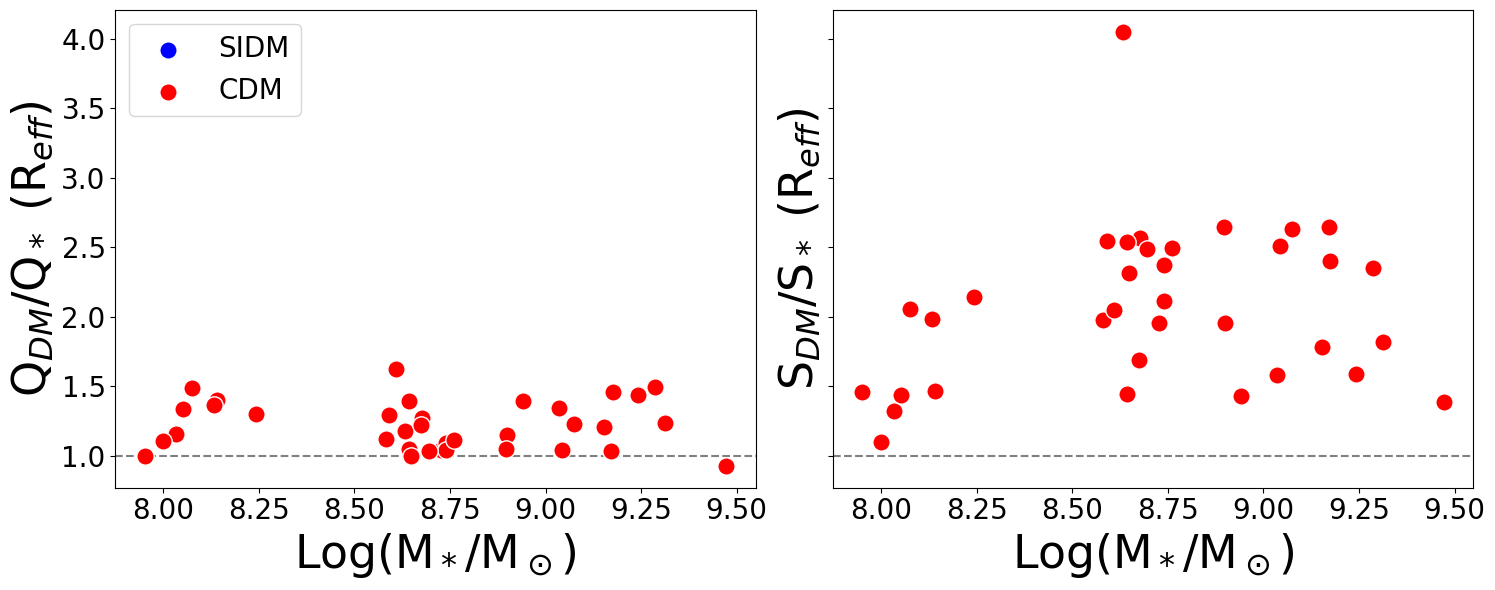

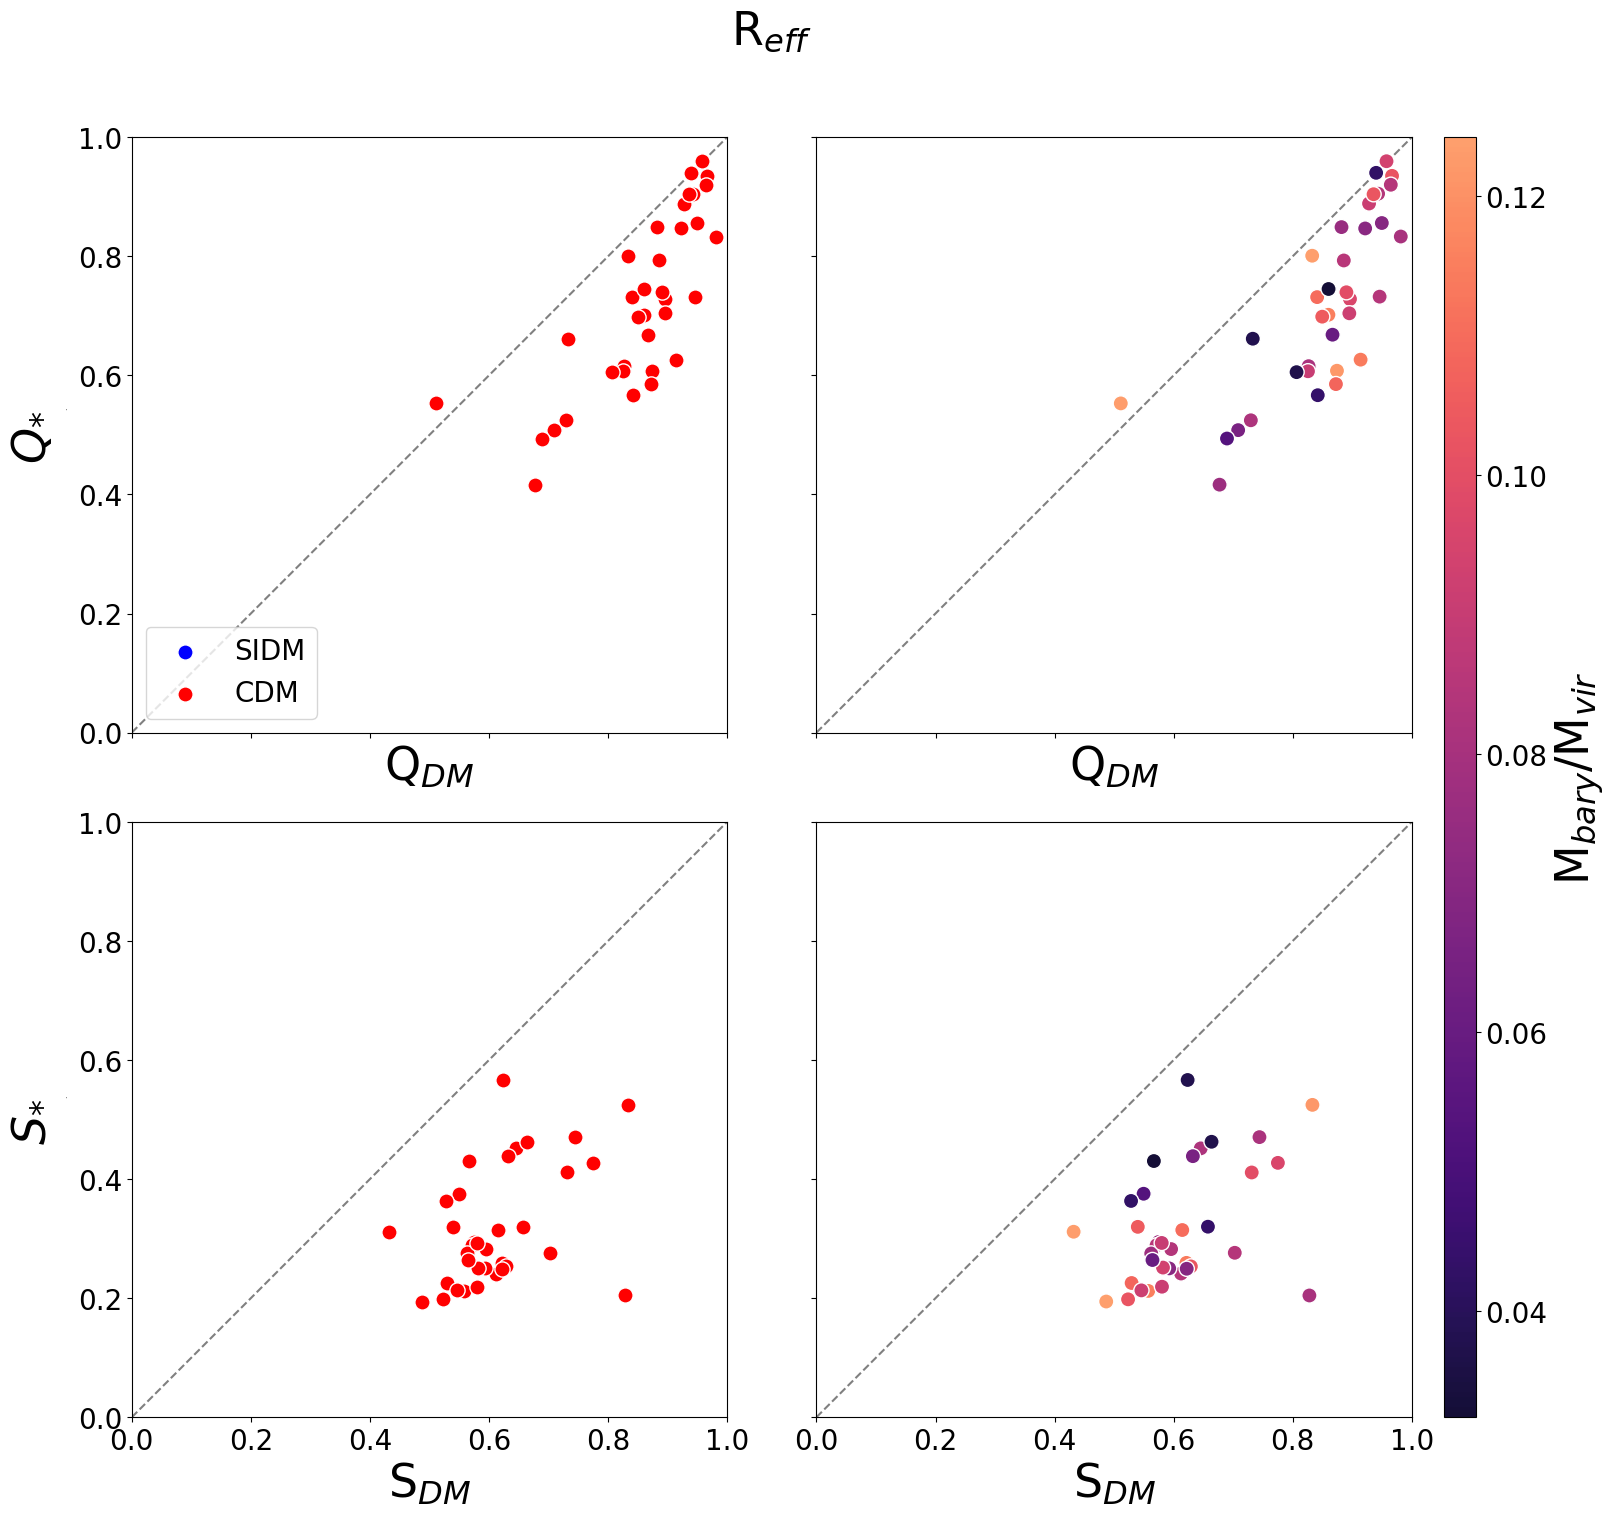

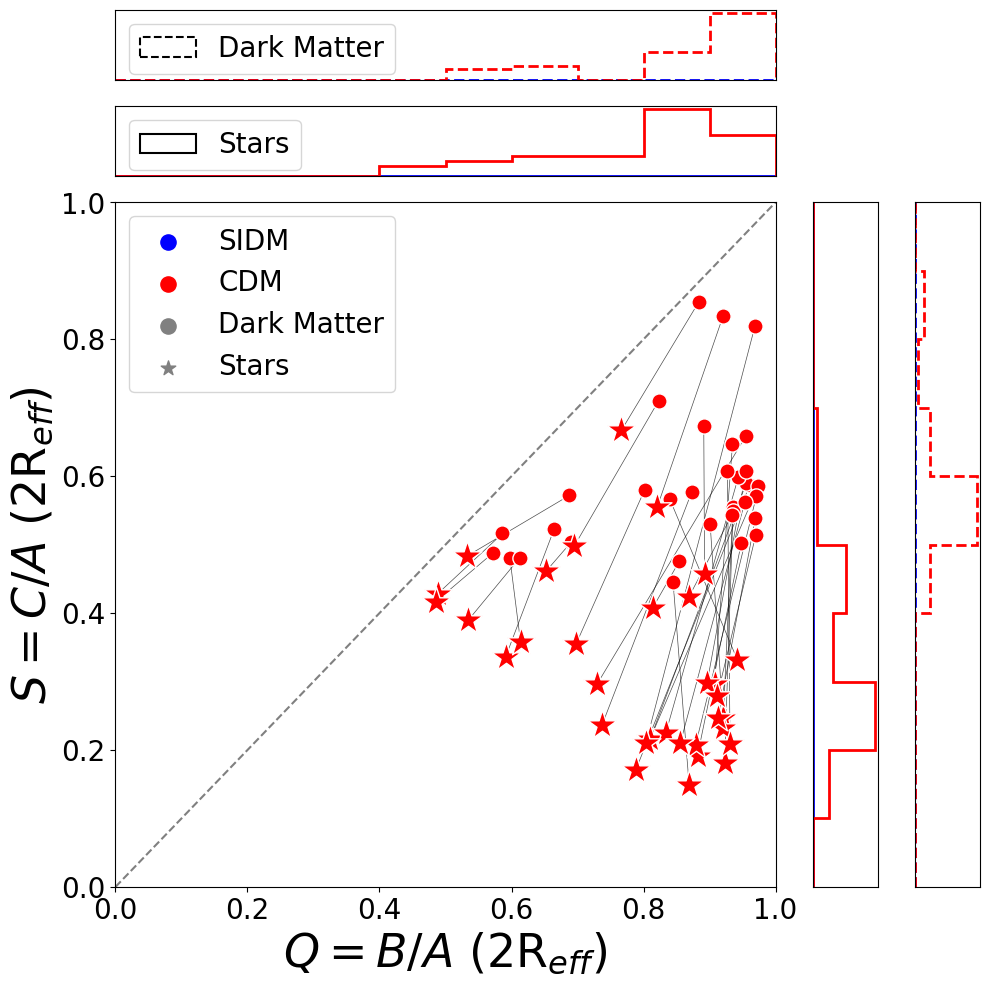

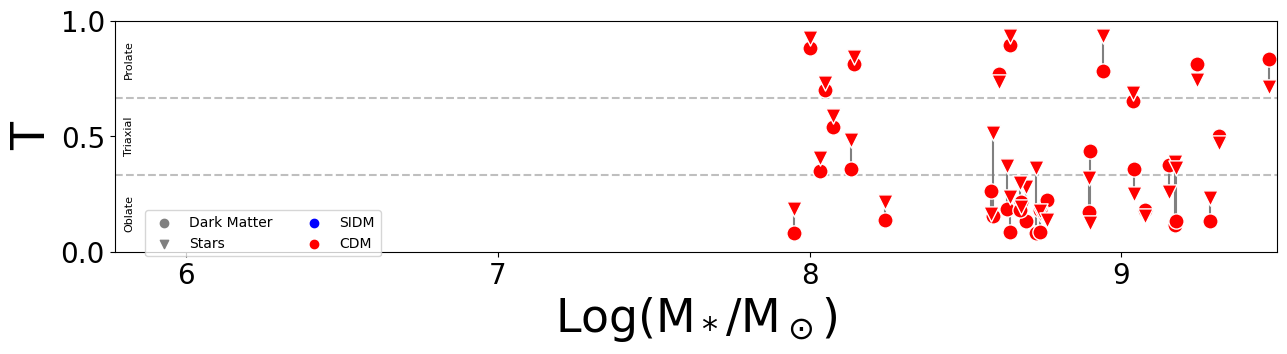

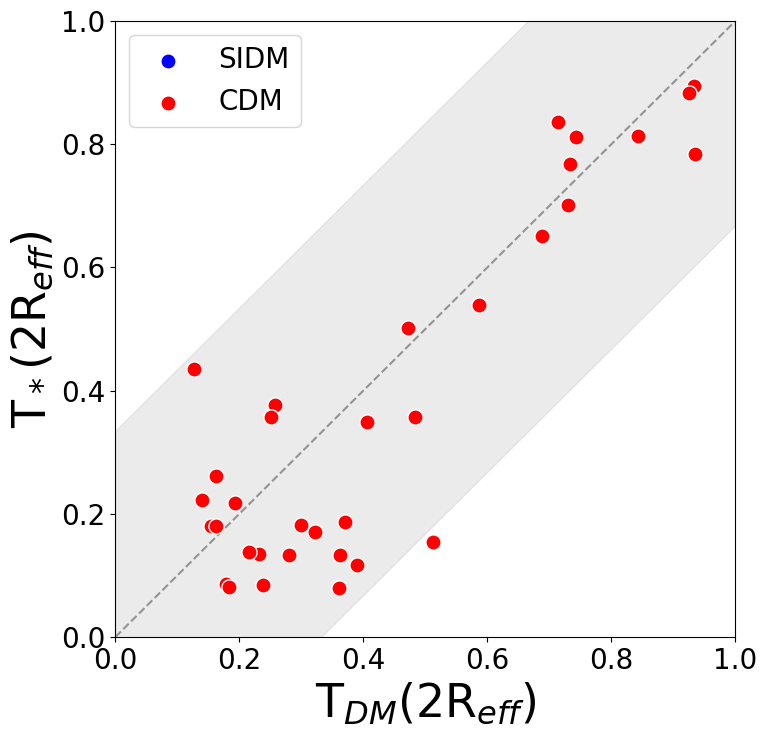

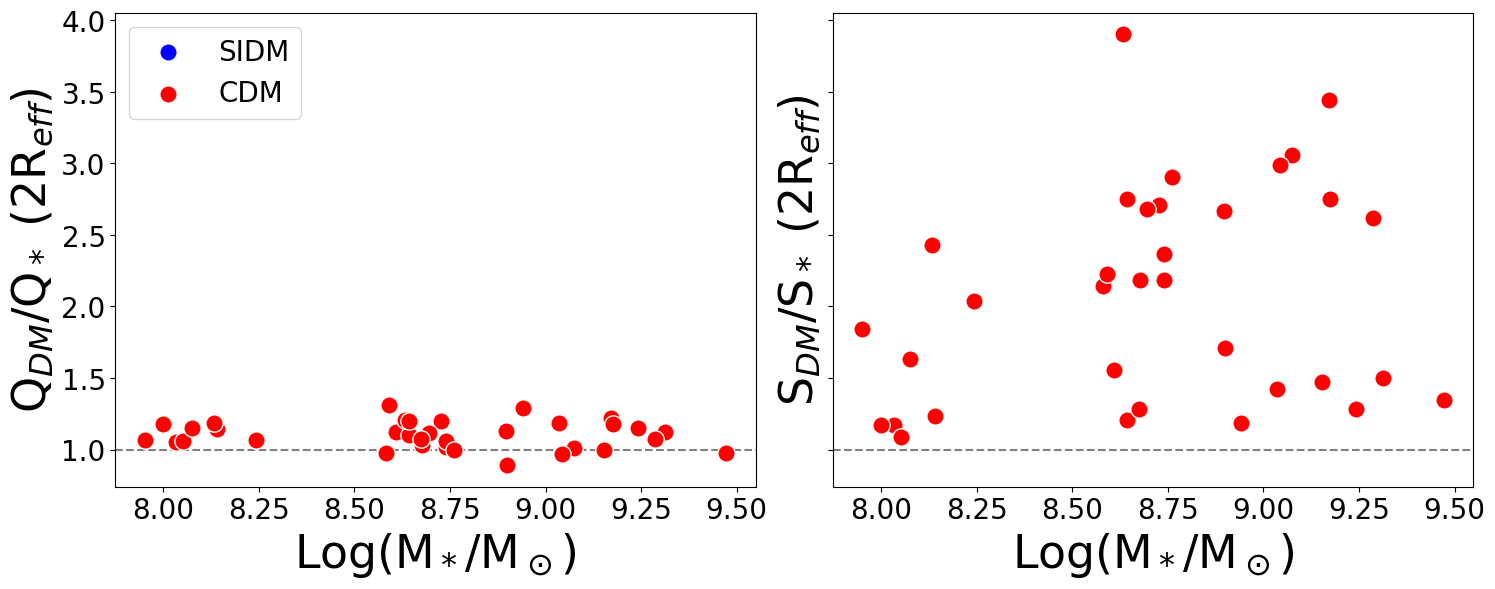

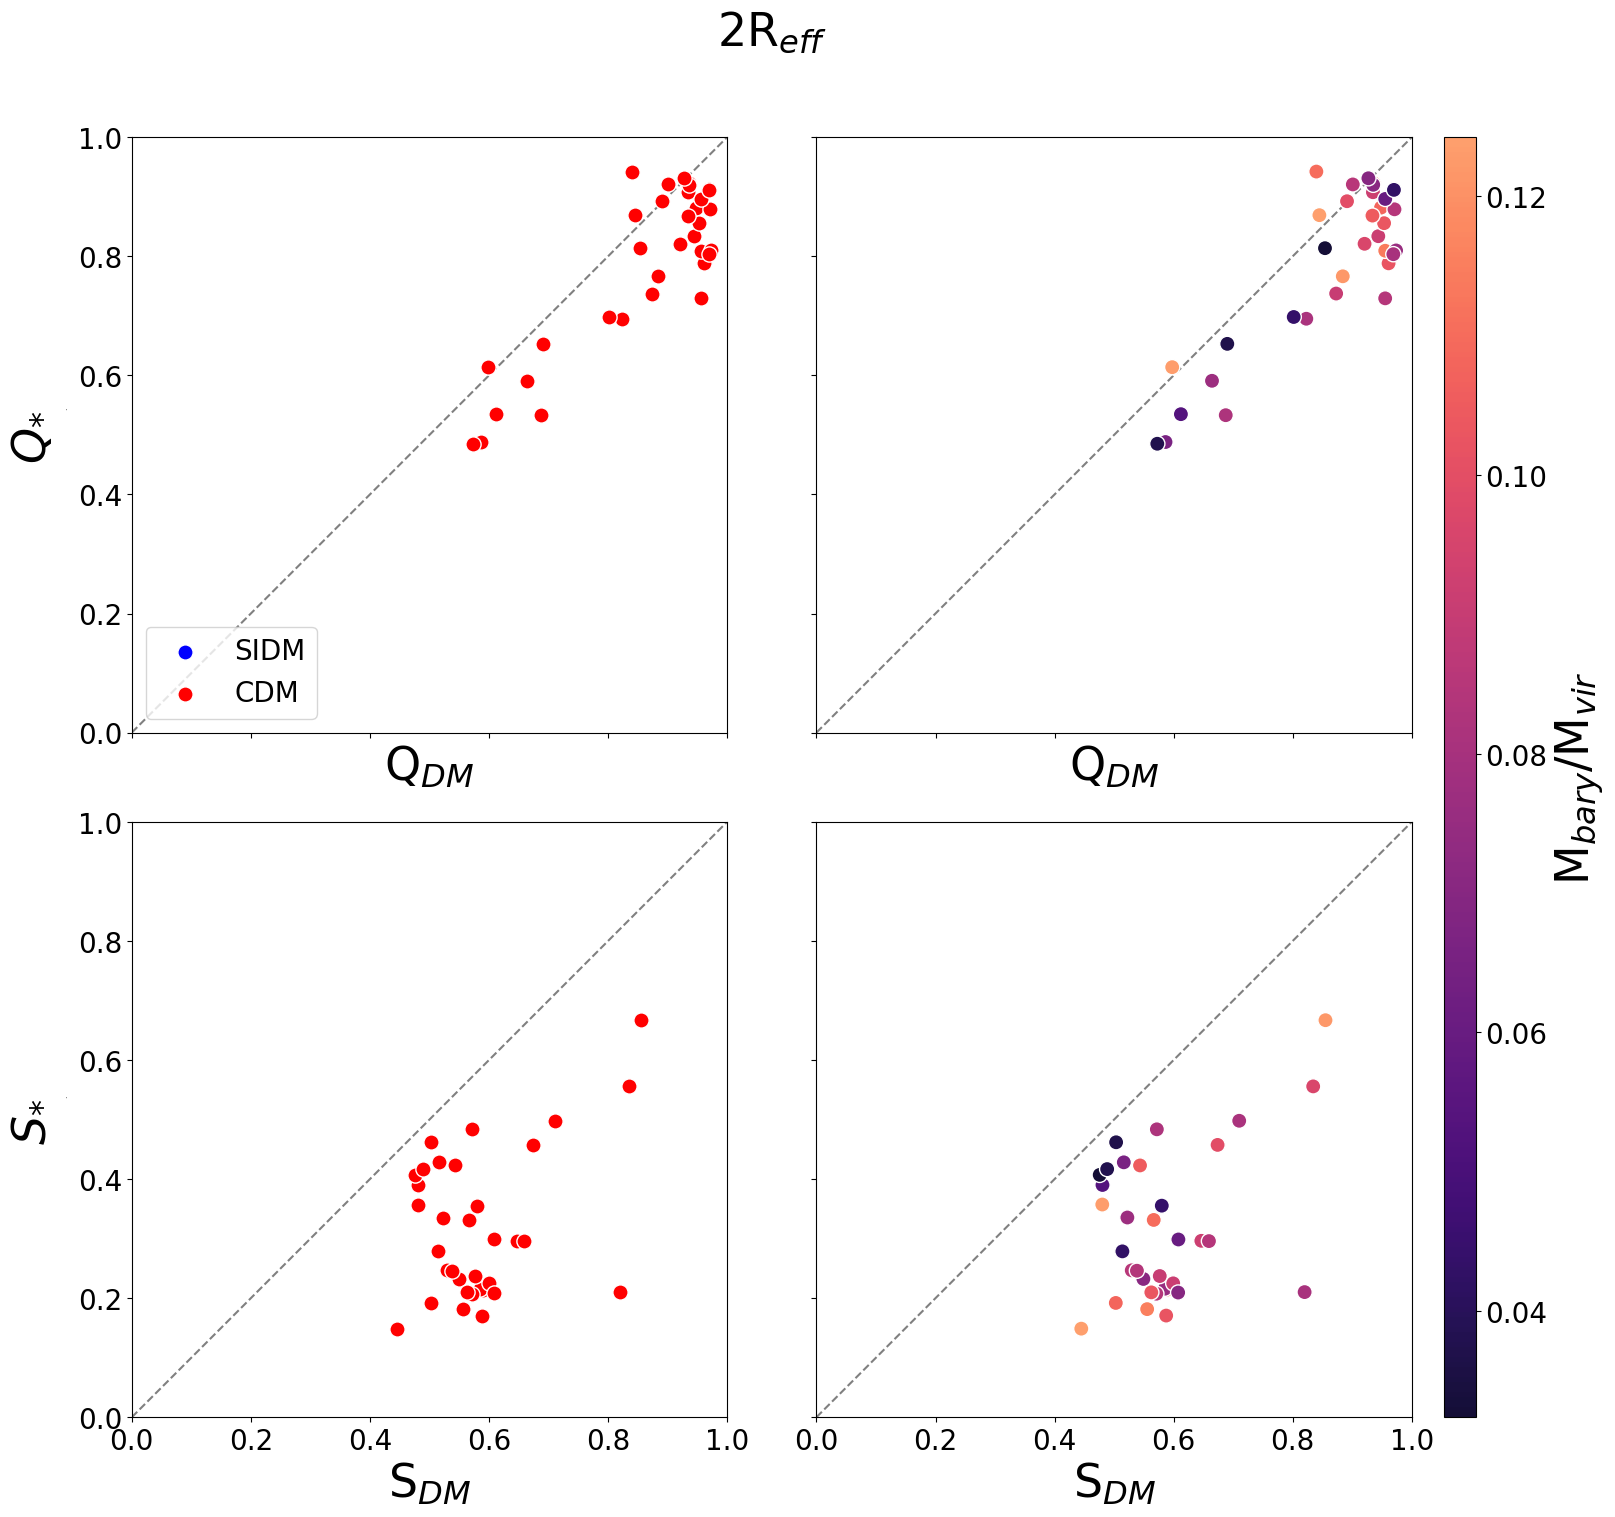

In [9]:
feedbacks = ['MerianSIDM', 'MerianCDM']
#feedbacks = [ 'MerianCDM']

import importlib
importlib.reload(sdt)
for reff_multi in [1,2]:
    B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,mb_reff,mb_10rvir,htype,reff,mvir,feedback_type,sims,hids,mergers,rvir,diffs_at_reff, jz_jcirc_avgs,t_dyn = sdt.LoadSimData(feedbacks,return_sims=True,reff_multi=reff_multi)

    #remove unphysical values where c > b or c < .1
    mask = (C_s < .1)
    B_s = B_s[~mask]
    C_s = C_s[~mask]
    T_s = T_s[~mask]
    B_d = B_d[~mask]
    C_d = C_d[~mask]
    T_d = T_d[~mask]
    masses = masses[~mask]
    mb = mb[~mask]
    mb_reff = mb_reff[~mask]
    mb_10rvir = mb_10rvir[~mask]
    htype = htype[~mask]
    reff = reff[~mask]
    mvir = mvir[~mask]
    feedback_type = feedback_type[~mask]
    sims = sims[~mask]
    hids = hids[~mask]
    #mergers = mergers[~mask]
    rvir = rvir[~mask]
    diffs_at_reff = diffs_at_reff[~mask]
    jz_jcirc_avgs = jz_jcirc_avgs[~mask]
    t_dyn = t_dyn[~mask]
    #print(len(sims))

    print(f'number in sample at reff_multi {reff_multi}: {len(sims)}')
    disk_sims = {}
    for feedback in feedbacks:
        # with open(f'galaxy_classifications_{feedback}.pickle', 'wb') as f:
        #     pickle.dump(classified_galaxies, f)
        try:
            with open(f'galaxy_classifications_{feedback}.pickle', 'rb') as f:
                classified_galaxies = pickle.load(f)
                disk_sims.update(classified_galaxies)
        except FileNotFoundError:
            print(f'File galaxy_classifications_{feedback}.pickle not found')
            continue







    #Usage example:
    #folder = '/home/bk639/OverLeaf/ShapePaper/figures/'
    folder = '/home/bk639/MorphologyMeasurements/Figures/SIDM_CDM_Shapes/'
    #make folder if it doesn't exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    SIDM_mask = feedback_type == 'MerianSIDM'
    CDM_mask = feedback_type == 'MerianCDM'

    data_plot = {
        'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
        'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir,'reff_multi':reff_multi
    }
    masks = {'SIDM': SIDM_mask, 'CDM': CDM_mask}
    labels = {'SIDM': 'SIDM', 'CDM': 'CDM', 'B': 'Q', 'C': 'S'}
    colors = {'SIDM': 'blue', 'CDM': 'red'}


    plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
    plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder +  f'SvQ_disky.{reff_multi}.png')
    plotter.calculate_shape_diff()
    plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass_disky.{reff_multi}.png')
    plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter_disky.{reff_multi}.png')
    plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s_disky.{reff_multi}.png')
    plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d.{reff_multi}.png')

In [3]:
feedback_type

array(['MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM',
       'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM',
       'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM',
       'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM',
       'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM',
       'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM',
       'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM', 'MerianCDM'],
      dtype='<U10')